In [1]:
import pickle
import json
import sys
import numpy as np
#
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, SpatialDropout1D, GlobalMaxPooling1D 
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-06-09 13:18:04.718463: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# in
trainingDumpFile = 'training/prepared_dataset/training_data.pickle'
# out
trainedModelFile = 'training/trained_model_v1/doc_classify_model.h5'
trainedMetadataFile = 'training/trained_model_v1/doc_metadata.json'
trainedTokenizerFile = 'training/trained_model_v1/doc_tokenizer.json'


print('TRAINING MODEL')

# load the training data and extract its parts
print('    Loading training data ... ', end ='')
data = pickle.load(open(trainingDumpFile, 'rb'))
X_test = data['X_test']
X_train = data['X_train']
y_test = data['y_test']
y_train = data['y_train']
labelLegendInverted = data['label_legend_inverted']
labelLegend = data['label_legend']
maxSeqLength = data['max_seq_length']
maxNumWords = data['max_words']
tokenizer = data['tokenizer']
print('done')

    

TRAINING MODEL
    Loading training data ... done


In [3]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [4]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix('training/pretrained_embeddings/glove.6B.100d.txt', tokenizer.word_index, embedding_dim)

In [5]:
vocab_size = len(tokenizer.word_index) + 1

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.6547755442141444

In [6]:


def create_model_by_version(version):
    # Model preparation
    print('    Initializing model ... ', end ='')
    embedDim = 256
    LstmOut = 196
    #
    model = Sequential()
    if version == 1:
        # V1: No pre-trained weights

        model.add(Embedding(maxNumWords, embedDim))

    elif version == 2:

        # V2: pre-trained weights => NO fine-tune
        model.add(Embedding(vocab_size, embedding_dim, 
                                   weights=[embedding_matrix], 
                                   input_length=maxNumWords, 
                                   trainable=False))

    else:
        
        # V3: pre-trained weights => fine-tune
        model.add(Embedding(vocab_size, embedding_dim, 
                                   weights=[embedding_matrix], 
                                   input_length=maxNumWords, 
                                   trainable=True))

    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(11, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
        

## Model V1

In [7]:
model = create_model_by_version(1)
model.summary()

    Initializing model ... 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Training
print('    Training ... ', end ='')
batchSize = 32
epochs = 20
callback = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=batchSize, verbose=1,
          epochs=epochs, callbacks=[callback])
print('done')



    Training ... Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 912ms/step - accuracy: 0.0914 - loss: 2.3925 - val_accuracy: 0.0937 - val_loss: 2.3679
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 861ms/step - accuracy: 0.1947 - loss: 2.2953 - val_accuracy: 0.2397 - val_loss: 2.2778
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 819ms/step - accuracy: 0.3217 - loss: 2.1305 - val_accuracy: 0.3526 - val_loss: 2.0708
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 864ms/step - accuracy: 0.5080 - loss: 1.8259 - val_accuracy: 0.5041 - val_loss: 1.7022
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 832ms/step - accuracy: 0.5994 - loss: 1.4710 - val_accuracy: 0.5950 - val_loss: 1.3526
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 835ms/step - accuracy: 0.6799 - loss: 1.1177 - val_accuracy: 0.7190 - val_loss: 1.0686
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 819ms/step - accuracy: 0.7057 - loss: 0.9638 - val_accuracy: 0.7025 - val_loss: 0.9579
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 823ms/step - accuracy: 0.7654 - loss: 

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

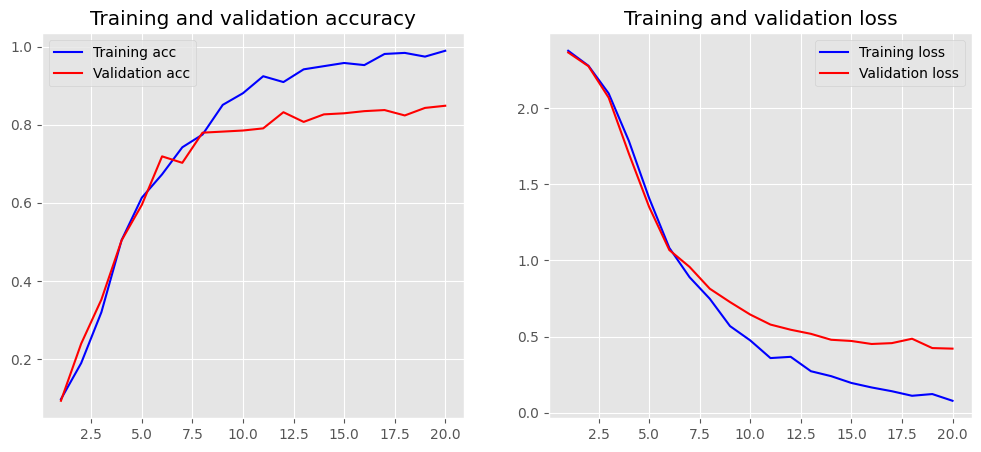

In [10]:
plot_history(history)

In [11]:
# 1. Save the model proper (the model has its own format and its I/O methods)
print('    Saving model ... ', end ='')

model.save(trainedModelFile)

print('done')

# for later self-contained use in the API then we need:
#     the model (hdf5 file), saved above
#     some metadata, that we will export now as JSON for interoperability:
#         labelLegendInverted
#         labelLegend
#         maxSeqLength
#         maxNumWords
#     and finally the tokenizer itself




    Saving model ... done


In [12]:
# 2. save a JSON with the metadata needed to 'run' the model
print('    Saving metadata ... ', end ='')
metadataForExport = {
    'label_legend_inverted': labelLegendInverted,
    'label_legend': labelLegend,
    'max_seq_length': maxSeqLength,
    'max_words': maxNumWords,
}
json.dump(metadataForExport, open(trainedMetadataFile, 'w'))

print('done')

    Saving metadata ... done


In [13]:
# 3. dump the tokenizer. This is in practice a JSON, but the tokenizer
#    offers methods to deal with that:
print('    Saving tokenizer ... ', end ='')
tokenizerJson = tokenizer.to_json()

with open(trainedTokenizerFile, 'w') as f:
    f.write(tokenizerJson)

print('done')
#
print('FINISHED')

    Saving tokenizer ... done
FINISHED


### MODEL V2


In [14]:
model = create_model_by_version(2)
model.summary()

    Initializing model ... 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     3,840,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,840,400 (14.65 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,840,400 (14.65 MB)

In [15]:
# Training
print('    Training ... ', end ='')
batchSize = 32
epochs = 20
callback = EarlyStopping(monitor='loss',patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=batchSize, verbose=1,
          epochs=epochs, callbacks=[callback])
print('done')

    Training ... Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.0924 - loss: 2.9466 - val_accuracy: 0.2039 - val_loss: 2.3015
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.1704 - loss: 2.2449 - val_accuracy: 0.2094 - val_loss: 2.1753
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.1890 - loss: 2.1708 - val_accuracy: 0.3003 - val_loss: 2.0739
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.2535 - loss: 2.0379 - val_accuracy: 0.2865 - val_loss: 1.9735
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.3660 - loss: 1.8504 - val_accuracy: 0.3939 - val_loss: 1.8234
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.4221 - loss: 1.7609 - val_accuracy: 0.5207 - val_loss: 1.6930
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.4486 - loss: 1.6176 - val_accuracy: 0.5399 - val_loss: 1.5663
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.5596 - loss: 1.4572 

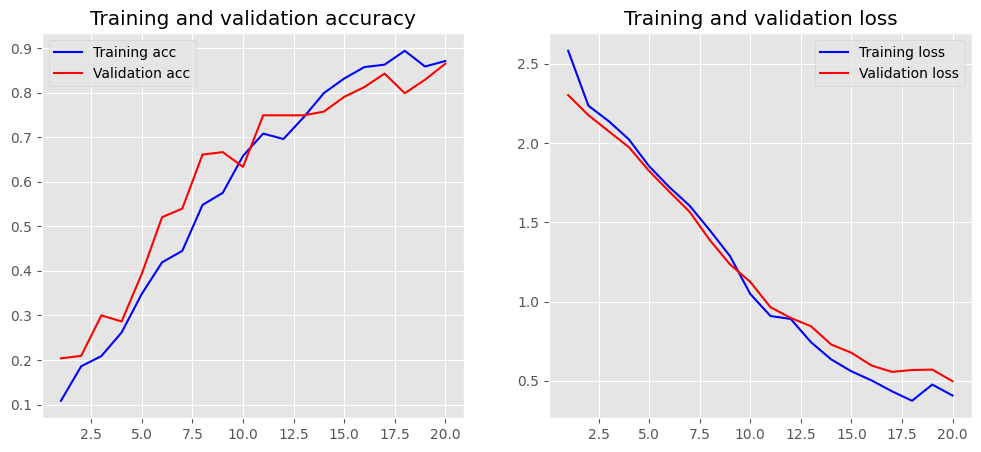

In [16]:
plot_history(history)

In [17]:
# Save the result (this involves three separate files)
# out
trainedModelFile = 'training/trained_model_v2/doc_classify_model.h5'
trainedMetadataFile = 'training/trained_model_v2/doc_metadata.json'
trainedTokenizerFile = 'training/trained_model_v2/doc_tokenizer.json'

# 1. Save the model proper (the model has its own format and its I/O methods)
print('    Saving model ... ', end ='')

model.save(trainedModelFile)

print('done')

# for later self-contained use in the API then we need:
#     the model (hdf5 file), saved above
#     some metadata, that we will export now as JSON for interoperability:
#         labelLegendInverted
#         labelLegend
#         maxSeqLength
#         maxNumWords
#     and finally the tokenizer itself




    Saving model ... done


In [18]:
# 2. save a JSON with the metadata needed to 'run' the model
print('    Saving metadata ... ', end ='')
metadataForExport = {
    'label_legend_inverted': labelLegendInverted,
    'label_legend': labelLegend,
    'max_seq_length': maxSeqLength,
    'max_words': maxNumWords,
}
json.dump(metadataForExport, open(trainedMetadataFile, 'w'))

print('done')

    Saving metadata ... done


In [19]:
# 3. dump the tokenizer. This is in practice a JSON, but the tokenizer
#    offers methods to deal with that:
print('    Saving tokenizer ... ', end ='')
tokenizerJson = tokenizer.to_json()

with open(trainedTokenizerFile, 'w') as f:
    f.write(tokenizerJson)

print('done')
#
print('FINISHED')

    Saving tokenizer ... done
FINISHED


## Model V3

In [20]:
model = create_model_by_version(3)
model.summary()

    Initializing model ... 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     3,840,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,840,400 (14.65 MB)

 Trainable params: 3,840,400 (14.65 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Training
print('    Training ... ', end ='')
batchSize = 32
epochs = 20
callback = EarlyStopping(monitor='loss',patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=batchSize, verbose=1,
          epochs=epochs, callbacks=[callback])
print('done')


    Training ... Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 379ms/step - accuracy: 0.1237 - loss: 2.4259 - val_accuracy: 0.2369 - val_loss: 2.2413
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 372ms/step - accuracy: 0.2007 - loss: 2.1742 - val_accuracy: 0.2837 - val_loss: 1.9796
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - accuracy: 0.3140 - loss: 1.8933 - val_accuracy: 0.5179 - val_loss: 1.6860
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - accuracy: 0.4595 - loss: 1.6150 - val_accuracy: 0.6556 - val_loss: 1.3984
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.5239 - loss: 1.4033 - val_accuracy: 0.6970 - val_loss: 1.1547
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - accuracy: 0.6507 - loss: 1.0833 - val_accuracy: 0.6942 - val_loss: 1.0693
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - accuracy: 0.6330 - loss: 1.0628 - val_accuracy: 0.8182 - val_loss: 0.7964
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 403ms/step - accuracy: 0.7038 - loss: 0.

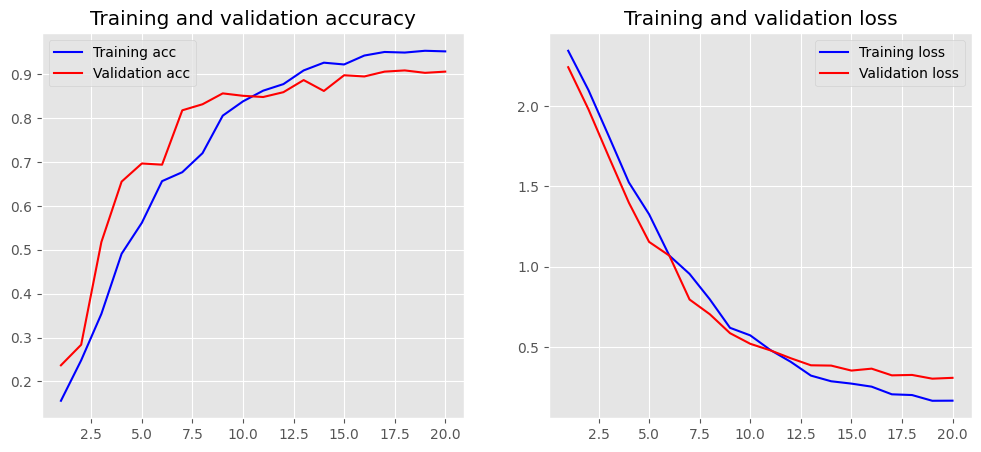

In [22]:
plot_history(history)

In [23]:
# Save the result (this involves three separate files)
# out
trainedModelFile = 'training/trained_model_v3/doc_classify_model.h5'
trainedMetadataFile = 'training/trained_model_v3/doc_metadata.json'
trainedTokenizerFile = 'training/trained_model_v3/doc_tokenizer.json'

# 1. Save the model proper (the model has its own format and its I/O methods)
print('    Saving model ... ', end ='')

model.save(trainedModelFile)

print('done')

# for later self-contained use in the API then we need:
#     the model (hdf5 file), saved above
#     some metadata, that we will export now as JSON for interoperability:
#         labelLegendInverted
#         labelLegend
#         maxSeqLength
#         maxNumWords
#     and finally the tokenizer itself





    Saving model ... done


In [24]:
# 2. save a JSON with the metadata needed to 'run' the model
print('    Saving metadata ... ', end ='')
metadataForExport = {
    'label_legend_inverted': labelLegendInverted,
    'label_legend': labelLegend,
    'max_seq_length': maxSeqLength,
    'max_words': maxNumWords,
}
json.dump(metadataForExport, open(trainedMetadataFile, 'w'))

print('done')

    Saving metadata ... done


In [25]:
# 3. dump the tokenizer. This is in practice a JSON, but the tokenizer
#    offers methods to deal with that:
print('    Saving tokenizer ... ', end ='')
tokenizerJson = tokenizer.to_json()

with open(trainedTokenizerFile, 'w') as f:
    f.write(tokenizerJson)

print('done')
#
print('FINISHED')

    Saving tokenizer ... done
FINISHED
